In [112]:
import math
import simpy
import random
import statistics
import matplotlib.pyplot as plt

In [113]:
metrics = {"wait_times": [], "declining_count": 0, "queue_time": []}

In [114]:
class Warehouse(object):
    def __init__(self, env, num_cars: int, num_loaders: int):
        self.env = env
        self.car = simpy.Resource(env, num_cars)
        self.loader = simpy.Resource(env, num_loaders)

    def unload_car(self, car, logging, arrival_time):
        if logging:
            print("unloading... time is:%f" % self.env.now)
        metrics["queue_time"].append(env.now - arrival_time)
        yield self.env.timeout(random.expovariate(1))

In [115]:
def car_unloading(env, car, warehouse, logging):
    arrival_time = env.now
    if warehouse.car.count != warehouse.car.capacity:
        with warehouse.car.request() as car_request:
            yield car_request
            with warehouse.loader.request() as request:
                yield request
                yield env.process(warehouse.unload_car(car, logging, arrival_time))
        metrics["wait_times"].append(env.now - arrival_time)
    else:
        metrics["declining_count"] += 1
        if logging:
            print("queue is full... time is:%f" % env.now)
        yield from [] # queue is full

In [116]:
def unloading_warehouse(env, num_cars, num_loaders, logging):
    warehouse = Warehouse(env, num_cars, num_loaders)
    car = 0
    while True:
        yield env.timeout(random.expovariate(3))
        car += 1
        env.process(car_unloading(env, car, warehouse, logging))

In [117]:
def get_average_wait_time(wait_times):
    average_wait = statistics.mean(wait_times)
    # Pretty print the results
    hours, frac_hours = divmod(average_wait, 1)
    minutes = frac_hours * 60
    return round(hours), round(minutes)

def get_average_step(times):
    average_step = statistics.mean(times)
    hours, minutes = divmod(average_step, 60)
    return round(hours), round(minutes)

In [118]:
# Run the simulation 100 times
average = []
average_declining = []
average_queue_time = []
for i in range(100):
    metrics["wait_times"] = []
    metrics["declining_count"] = 0
    metrics["queue_time"] = []
    #reset to default values
    env = simpy.Environment()
    num_cars, num_loaders, logging = 7, 3, False
    env.process(unloading_warehouse(env, num_cars, num_loaders, logging))
    duration = 7*24#1 week
    env.run(until=duration)
    hours, minutes = get_average_wait_time(metrics["wait_times"])
    average.append(minutes + hours * 60)
    average_declining.append(metrics["declining_count"])
    average_queue_time.append(statistics.mean(metrics["queue_time"]))
    
average_hours, average_minutes = get_average_step(average)
# View the results
print("Running simulation...")
print(f"{statistics.mean(average_declining)} times of declining car, because queue is full")
#some of the characteristics
print(f"\nThe average wait time is {average_hours} hours and {average_minutes} minutes.")
print(f"Relative throughput is {1 - statistics.mean(average_declining)/duration/3}")
print(f"Absolute throughput is {3 - statistics.mean(average_declining)/duration}")
print(f"Probability of refusal to the request is {statistics.mean(average_declining)/duration/3}")
print(f"Average waiting time of the request in the queue is {statistics.mean(average_queue_time)}")

Running simulation...
72.05 times of declining car, because queue is full

The average wait time is 1 hours and 33 minutes.
Relative throughput is 0.8570436507936507
Absolute throughput is 2.5711309523809525
Probability of refusal to the request is 0.1429563492063492
Average waiting time of the request in the queue is 0.5564566257376455


Running simulation... 
The average wait time is 1 hours and 31 minutes.


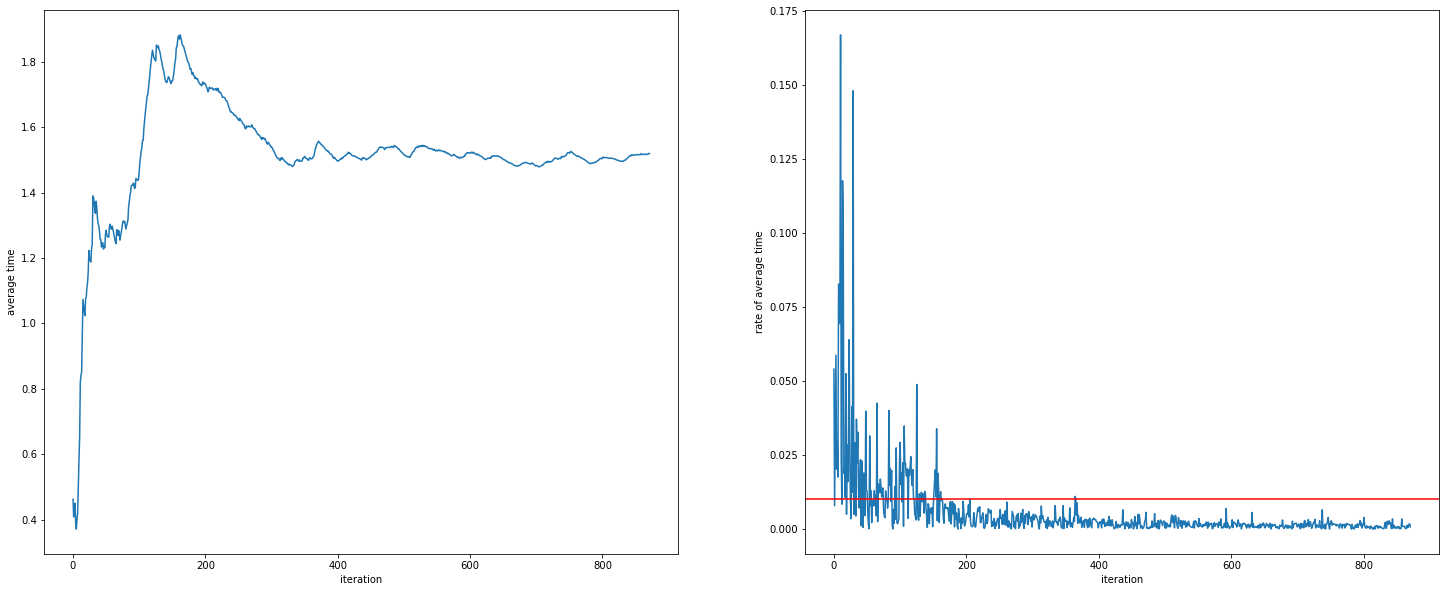

In [119]:
#checking convergence rate
metrics["wait_times"] = []
metrics["declining_count"] = 0
#reset to default values
env = simpy.Environment()
num_cars, num_loaders, logging = 7, 3, False
env.process(unloading_warehouse(env, num_cars, num_loaders, logging))
env.run(until=14*24)#2 weeks
hours, minutes = get_average_wait_time(metrics["wait_times"])
x = range(len(metrics["wait_times"]))#x = step
means = [statistics.mean(metrics["wait_times"][:i+1]) for i, el in enumerate(metrics["wait_times"])]
def calculate_rate(arr):
    rates = []
    for i in range(len(arr) - 1):
        rate = abs(arr[i + 1] - arr[i])
        rates.append(rate)
    return rates
rates = calculate_rate(means)
epsilon = 0.01

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (25, 10))
ax1.plot(x, means)
ax1.set_xlabel("iteration")
ax1.set_ylabel("average time")
ax2.plot(x[:len(x) - 1], rates)
ax2.set_xlabel("iteration")
ax2.set_ylabel("rate of average time")
ax2.axhline(y=epsilon, color='r', linestyle='-')

print("Running simulation...",f"\nThe average wait time is {hours} hours and {minutes} minutes.")

Running simulation... 
The average wait time is 1 hours and 34 minutes.


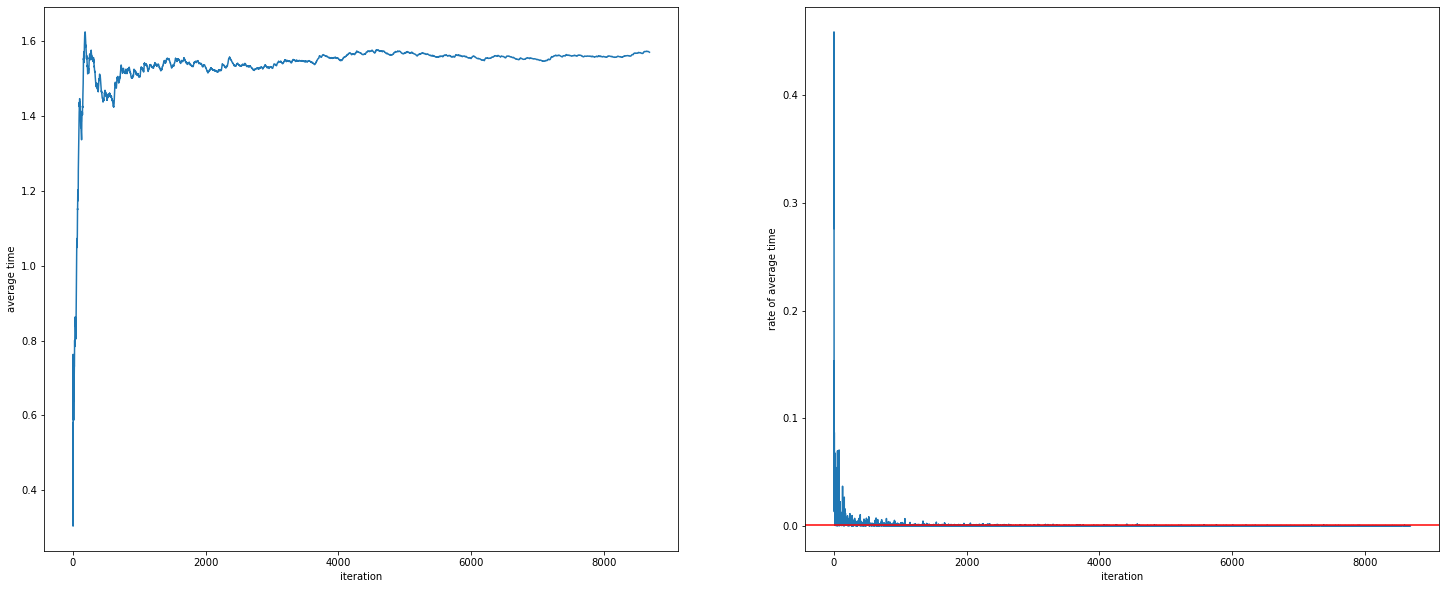

In [120]:
# Run the simulation for a long time(20 weeks)
metrics["wait_times"] = []
metrics["declining_count"] = 0
#reset to default values
env = simpy.Environment()
num_cars, num_loaders, logging = 7, 3, False
env.process(unloading_warehouse(env, num_cars, num_loaders, logging))
env.run(until=140*24)#long time to converge 20 weeks
hours, minutes = get_average_wait_time(metrics["wait_times"])
x = range(len(metrics["wait_times"]))#x = step
means = [statistics.mean(metrics["wait_times"][:i+1]) for i, el in enumerate(metrics["wait_times"])]
def calculate_rate(arr):
    rates = []
    for i in range(len(arr) - 1):
        rate = abs(arr[i + 1] - arr[i])
        rates.append(rate)
    return rates
rates = calculate_rate(means)
epsilon = 0.001#changed to see that it converge 

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (25, 10))
ax1.plot(x, means)
ax1.set_xlabel("iteration")
ax1.set_ylabel("average time")
ax2.plot(x[:len(x) - 1], rates)
ax2.set_xlabel("iteration")
ax2.set_ylabel("rate of average time")
ax2.axhline(y=epsilon, color='r', linestyle='-')

print("Running simulation...",f"\nThe average wait time is {hours} hours and {minutes} minutes.")